# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00


In [4]:
import torch
import numpy as np
from dataset import TextDataset

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [8]:
from torch import optim
from torch import nn
from train import train
from torch.utils.data import DataLoader

In [ ]:
num_epochs = 20
batch_size = 128

In [ ]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
rnn_model = LanguageModel(train_set).to(device)
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=1e-3)
rnn_scheduler = optim.lr_scheduler.CosineAnnealingLR(rnn_optimizer, T_max=num_epochs)

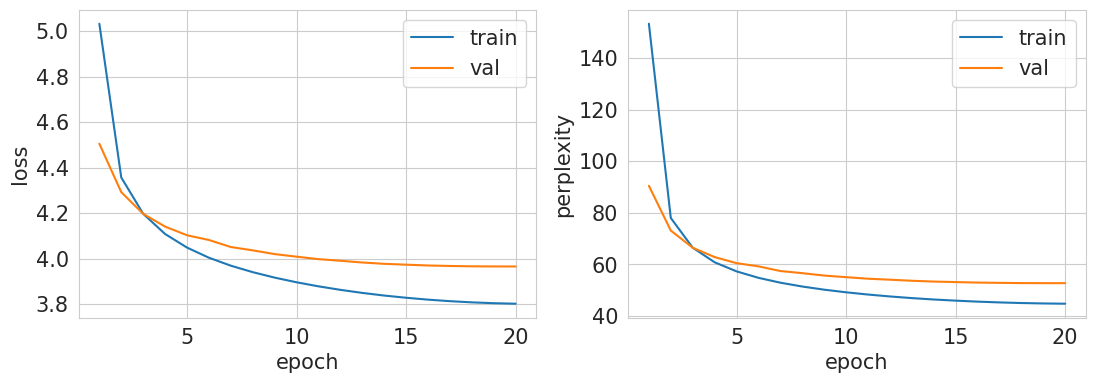

Generation examples after epoch=20:
людядьдядбойбедоддьбудодьдодиххохсялидододядододстдобойкохдододокродохтойддодячадодододододядьдодододододьдьдядододэкусдядоходобойдододододьмидясясдьдофдодохдододокдьдоходобадохбысдододододьдьдодсдябойдододододосядодододобойдододобаэкдядодододоковкдодокибойдододоетедодьддодядьдобойдоддодобадододьбадоддодядододестрадьсдододьтовдьддододобойхдьдьхдьдохстдохбойдьдододододобахдоддьдодьдобойдошбойстдоддододобудобойдобякамидобойдьбойдихододьдододобудьдьбымсьдодобойдододьдотовстхссстдодьходосдодотыкладомдокмстбудододододдьдодьдодьдьдобойдодомдододябойдьбддь?ддьдядомиенедодобойдододододядододододбакдьдосяддхдобадодододододядодябойтыдододдьддодьдодьбойдодьдьдядобадомедостдодьдохдобойдодолыбойкбойдбойшейрадостдододохсьдодобыбядодосткбойдодядододьдододобыдододододыхобадядьдодьходододододьдьдододябойдьдедядодядодютбыдодододякдобакадьдододододододядодьдобыдодоитьтыбойдкидьдобойхдобамидоэкдебойхдьбубубемихододьхдядбыдястрадьдодя недододострабойдядододдодьдодододохд

In [ ]:
train(rnn_model, rnn_optimizer, rnn_scheduler, train_loader, val_loader, num_epochs=num_epochs)

In [ ]:
torch.save(rnn_model.state_dict(), 'rnn.model')
torch.save(rnn_optimizer.state_dict(), 'opt_rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [ ]:
lstm_model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=1e-3)
lstm_scheduler = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer, T_max=num_epochs)

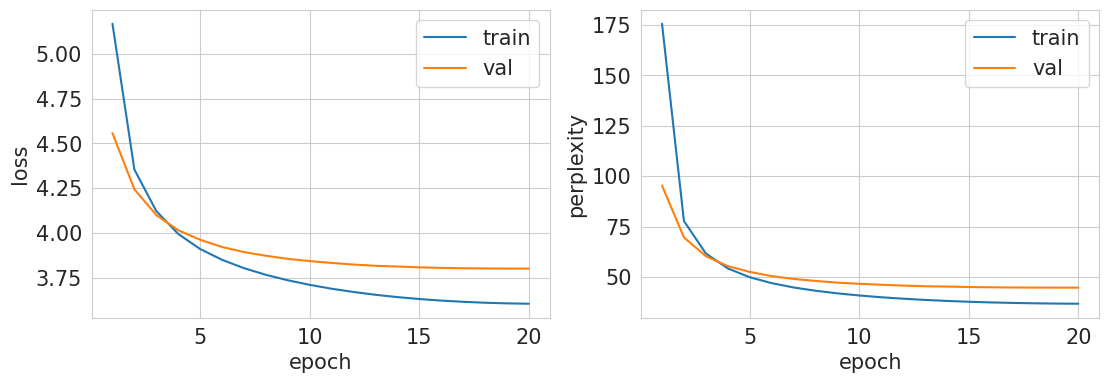

Generation examples after epoch=20:
- представля ба почему это ст что товари можно что давай сколько как попро что есть моя ми ты не мама спасибо моя работа тебя со на по а ника вы ты по улы дев ну жа ты никогда жа таки д у пи единствен програм пу другой из у теперь вто ки тебя по твой хоро я за ни папа за прода а это это сла уди а у са изви это по ре а теперь как сама краси си а мину сама ну если мама т хо без когда бе вчера возь я знаешь твой ты ро собака а все которая пода тебе сем один это люб всегда им вол ко тебе один это а первый ты ты твой ты мы самый надо бабушка если д с ко ника трам со ты пой ми и не ци может зо это только ма расска тебе что чай твоя ты м какой у а никогда будет это сказала вы когда гор иди с ку ле са улы папа ап це пы поня нет не люби при совер спе не и лю потер паци сама чет тебе то дорогая выход друго ку совсем много вы а ря без ле ничего сказала ба которы пой п на са пар дети мои а ты бес э ма как ты как ар луч три еврей твои смотри в со лишь ты жи а п б

In [ ]:
train(lstm_model, lstm_optimizer, lstm_scheduler, train_loader, val_loader, num_epochs=num_epochs)

perplexity примерно получилось одинаковые, а loss у LSTM поменьше. У LSTM как будто генерация текста больше похоже на речь


In [ ]:
torch.save(lstm_model.state_dict(), 'lstm.model')
torch.save(lstm_optimizer.state_dict(), 'opt_lstm.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
prefixes = ['вовочка', 'встречаются армянин, хохол и русский', 'приходит обама', 'разработчик текила нейросеть']
temps = np.linspace(0.1, 2, 10)

In [ ]:
for prefix in prefixes:
  for temp in temps:
    generated = lstm_model.inference(prefix, temp)
    print('----------')
    print('prefix: ', prefix)
    print('temp: ', temp)
    print('RNN: ', rnn_model.inference(prefix, temp))
    print('LSTM: ', lstm_model.inference(prefix, temp))

----------
prefix:  вовочка
temp:  0.1
RNN:  вовочка приходит домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой домой до

По температуре более менее какие то внятные слова выдавались на промежутке 1.15-1.57 и на 2.0

Каких то внятных текстов как хотелось бы у меня не получилось, кажется RNN и LSTM выдают примерно одинаково, но иногда LSTM выдает что то более осмысленное поэтому ниже буду использовать именно эту модель

По префиксам кажется работает лучше если написать что-то более осмысленное, нежели просто набор разных слов

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=True, sp_model_prefix='bpe4000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=False, sp_model_prefix='bpe4000')


In [ ]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
lstm_model_4000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer_4000 = optim.AdamW(lstm_model_4000.parameters(), lr=1e-3)
lstm_scheduler_4000 = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer_4000, T_max=num_epochs)

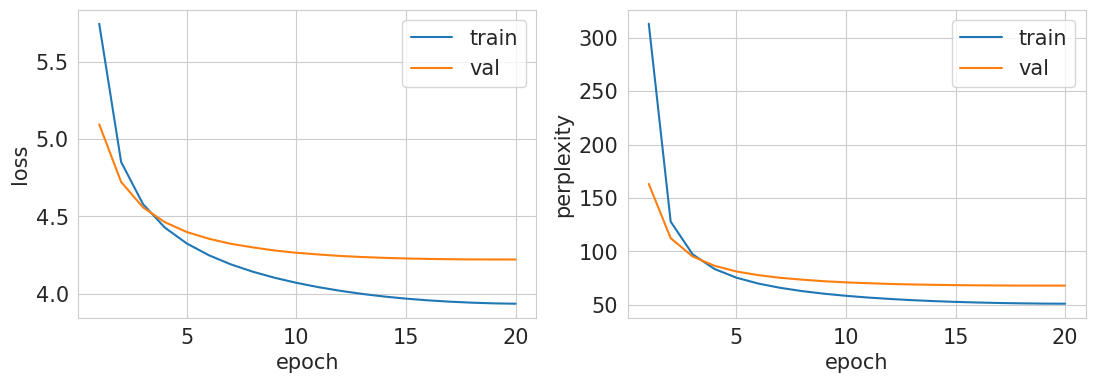

Generation examples after epoch=20:
освыеньловенведитьпиужужужматритамдоваужужлушаужпиьтеилужужуждяужпиужужьтеуженужтитьтыужтитьжнонитематрильноепараенявердокьююдадьюдалкутьсяужужужтам сумюдасомдящеголымилетльныхльноеужхал колиниетиттуж чувствуюдащуюентссаужчегоютсяужпарадетехатьтраужссеьяжужнноьетужуж тойутбинымиписьчеговаетеди евлушаемсядокуждиужнимлогльноебемсяужруттьпить эстяныециона шутрмащемтужчерауж деньужуж русскийужпенрманныммыужбилиуждятженпититюдаужужющийутужтивенятывячегофоюдаматридияужюсьененольниктинанноголкурыхдишьситстлиндаужтиткольужужннымгрунитединомтради зарпланююпаужчегоюдаствительнопон плохаяпетюданытдаящийужнюющемновуждивалисьнияужменныемсяужкарресужнаужнитедимткиьютдаялоитесьрустьсяужшиментаженнавхойтуащаявыужщийлуша ничтоменанююдятитаужльное должнтаужюданаужерыужюданиемужтиттиттыужчешьженужуженадинетеужужткиткирот асфативитьсясадиужюлымязапаралушаужменты могуужкономльноещемусковужниетдуюлисьтина порняяужпараняяениемремяужльноежстяужлкойужнопбоктинаницупи которыу

In [ ]:
train(lstm_model_4000, lstm_optimizer_4000, lstm_scheduler_4000, train_loader, val_loader, num_epochs=num_epochs)

In [ ]:
torch.save(lstm_model_4000.state_dict(), 'lstm_4000.model')
torch.save(lstm_optimizer_4000.state_dict(), 'opt_lstm_4000.model')

In [ ]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, model_type='unigram', train=True, sp_model_prefix='unigram4000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, model_type='unigram', train=False, sp_model_prefix='unigram4000')


In [ ]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
lstm_model_unigram4000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer_unigram4000 = optim.AdamW(lstm_model_unigram4000.parameters(), lr=1e-3)
lstm_scheduler_unigram4000 = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer_unigram4000, T_max=num_epochs)

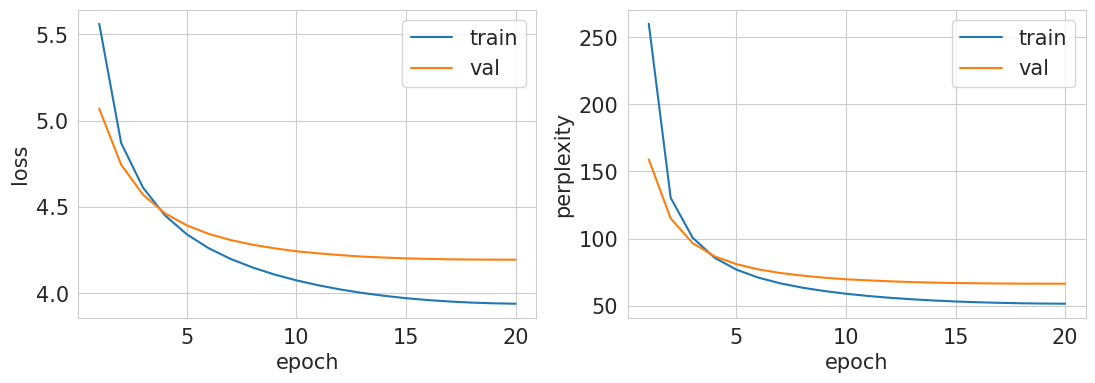

Generation examples after epoch=20:
женщине, легко да нужно нужно,- с... мам и будешь спит. и начал не? - за, ее. лет ты сам.ами с может предпоч рас приходил чего же. одев, хрен больше повод раз... хрен им любить еще должна надо и, созда. об... кур, и все, не. обид и и успел...-... и - будешь буду, по,!, больше.! нечего твоя, ок теперь и, приятно быть пол ему пере.. вместе, не, глаза зиму!, можно молча теперь страш! будем созда...- надо давно, лучше прямо! к до.- даже. от ту любовник и  спи потом тв спишь! увидеть слушать лучше мне, делать -. следует сломал хрен раз думать только... для и цел и какая женщину, будешь еще водку - потом он, нечего и мел! спокойно! и необходимо на...! раньше я.-! написано с будешь легче на не! - придется ты хрен? делать жен па... как следует...- пару!, может объ с хочешь сказать стар при и получается, интерес голова!. видел, крас она и так с баб... жрать позвони  же зл пожал ш уже и, больше строй... приду лет! свою и, чуть сегодня! никуда этой,, делать зво

In [ ]:
train(lstm_model_unigram4000, lstm_optimizer_unigram4000, lstm_scheduler_unigram4000, train_loader, val_loader, num_epochs=num_epochs)

In [ ]:
torch.save(lstm_model_unigram4000.state_dict(), 'lstm_unigram4000.model')
torch.save(lstm_optimizer_unigram4000.state_dict(), 'opt_lstm_unigram4000.model')

Результаты генерации получилось похожими

Но модели неправильно сравнивать по perplexity, так как эта метрика считается относительно изначальной работы токенайзера, а они для каждой модели разные.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def LSA(model: LanguageModel, data: TextDataset):
    n = len(data)
    texts = []
    for tokens, _ in data:
        texts.append(data.ids2text(tokens))

    for _ in range(n):
        texts.append(model.inference())

    vectorizer = TfidfVectorizer().fit(texts)
    texts_tf_idf = vectorizer.transform(texts).T

    svd = TruncatedSVD(n_components=100, random_state=42).fit(texts_tf_idf)

    vectors_val = svd.components_[:, :n]
    vectors_generated = svd.components_[:, n:]

    lsa = np.mean(np.max(cosine_similarity(vectors_val.T, vectors_generated.T), axis = 0))

    return lsa, vectors_val, vectors_generated

In [10]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=True, sp_model_prefix='bpe4000')
lstm_model_4000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_model_4000.load_state_dict(torch.load('lstm_4000.model', map_location=torch.device(device)))
lstm_model_4000.eval()

LanguageModel(
  (embedding): Embedding(4000, 256, padding_idx=42)
  (rnn): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=4000, bias=True)
)

In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
lstm_lsa, lstm_v_val, lstm_v_gen = LSA(lstm_model, valid_set)
lstm_lsa

0.5932377526118351

In [13]:
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=False, sp_model_prefix='bpe4000')
lstm_lsa_4000, lstm_v_val_4000, lstm_v_gen_4000 = LSA(lstm_model_4000, valid_set)
lstm_lsa_4000

0.640320174859709

In [ ]:
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, model_type='unigram', train=False, sp_model_prefix='unigram4000')
lstm_lsa_unigram4000, lstm_v_val_unigram4000, lstm_v_gen_unigram4000 = LSA(lstm_model_unigram4000, valid_set)
lstm_lsa_unigram4000

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
vectors_val_lstm = lstm_v_val[np.random.randint(lstm_v_val.shape[0], size=256)]
vectors_gen_lstm = lstm_v_gen[np.random.randint(lstm_v_gen.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm + vectors_gen_lstm)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm) / 2), 0], points[:int(len(vectors_val_lstm) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm) / 2):, 0], points[int(len(vectors_val_lstm) / 2):, 1], label='gen')

plt.legend()
plt.title('Визулизация для bpe токенайзера со словарем 2000')
plt.show()

In [ ]:
vec_val_lstm_4000 = lstm_v_val_4000[np.random.randint(lstm_v_val_4000.shape[0], size=256)]
vec_gen_lstm_4000 = lstm_v_gen_4000[np.random.randint(lstm_v_gen_4000.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vec_val_lstm_4000 + vec_gen_lstm_4000)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vec_val_lstm_4000) / 2), 0], points[:int(len(vec_val_lstm_4000) / 2), 1], label='val')
plt.scatter(points[int(len(vec_val_lstm_4000) / 2):, 0], points[int(len(vec_val_lstm_4000) / 2):, 1], label='gen')

plt.legend()
plt.title('Визуализация для bpe токенайзера c увеличенным словарем 4000')
plt.show()

In [ ]:
vectors_val_lstm_unigram4000 = lstm_v_val_unigram4000[np.random.randint(lstm_v_val_unigram4000.shape[0], size=256)]
vectors_gen_lstm_unigram4000 = lstm_v_gen_unigram4000[np.random.randint(lstm_v_gen_unigram4000.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm_unigram4000 + vectors_gen_lstm_unigram4000)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm_unigram4000) / 2), 0], points[:int(len(vectors_val_lstm_unigram4000) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm_unigram4000) / 2):, 0], points[int(len(vectors_val_lstm_unigram4000) / 2):, 1], label='gen')

plt.legend()
plt.title('Визулизация для unigram токенайзера со словарем 4000')
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_id = "ai-forever/rugpt3small_based_on_gpt2"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# https://huggingface.co/docs/transformers/perplexity

def ppl(model, checker_model, checker_tokenizer):
    size = 512
    texts = [model.inference() for _ in range(size)]

    encodings = checker_tokenizer("\n\n".join(texts), return_tensors="pt")

    max_length = checker_model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = checker_model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    return torch.exp(torch.stack(nlls).sum() / end_loc)

In [ ]:
ppl(lstm_model, model, tokenizer)

tensor(630.5265, device='cuda:0')

In [ ]:
ppl(lstm_model_4000, model, tokenizer)

tensor(1028.1995, device='cuda:0')

In [ ]:
ppl(lstm_model_unigram4000, model, tokenizer)

tensor(800.6697, device='cuda:0')

Получилось что у самой первой модели LSTM perplexity ниже

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Анекдоты как таковые что то не получились, но вот фразы:


- женщине, легко да нужно нужно

 - придется ты хрен?